In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
# from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.7.0.dev20250112+cu126
cuda:0


In [28]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms


# 定义数据集的变换
transform = transforms.Compose([
    transforms.ToTensor(), # 转换为tensor，进行归一化
    # transforms.Normalize(mean, std) # 标准化，mean和std是数据集的均值和方差
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分

In [29]:
type(train_ds)

torchvision.datasets.mnist.FashionMNIST

In [30]:
# 通过id取数据，取到的是一个元祖,是第一个样本,在训练时，把特征和标签分开
img, label = train_ds[0]
img.shape

torch.Size([1, 28, 28])

In [31]:
img[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510, 0.2863, 0.0000,
         0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000

In [18]:
img

In [26]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: (28, 28)
图像模式: L
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 13, 73, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 36, 136, 127, 62, 54, 0, 0, 0, 1, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 102, 204, 176, 134, 144, 123, 23, 0, 0, 0, 0, 12, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 236, 207, 178, 107, 156, 161, 109, 64, 23, 77, 130, 72, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141, 88, 172, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245, 173, 0, 0, 0, 

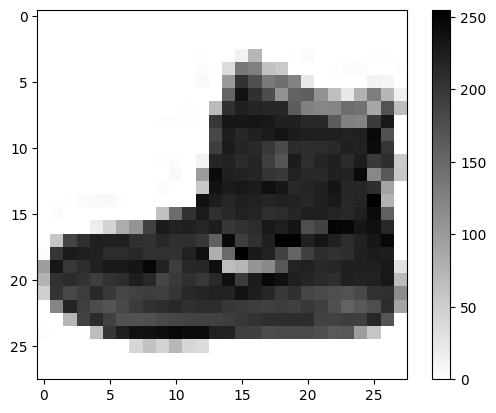

In [20]:

#这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")  # 显示图片
    plt.colorbar()  # 显示颜色条
    plt.show()


show_single_image(img)

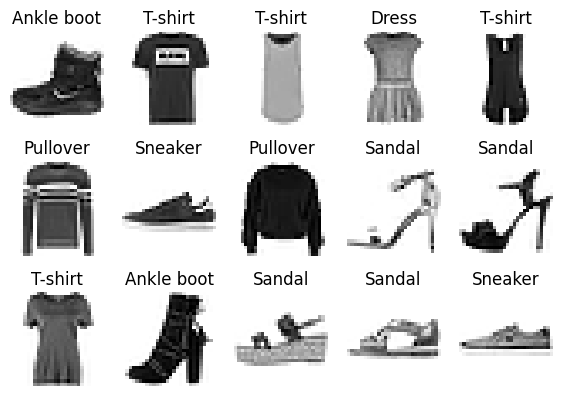

In [32]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            img_arr, label = train_ds[index]
            img_arr = np.transpose(img_arr, (1, 2, 0))  # 通道换到最后一维
            plt.imshow(img_arr, cmap="binary",
                       interpolation = 'nearest')#interpolation='nearest'是临近插值
            plt.axis('off')#去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()
    
    

#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(3, 5, train_ds, class_names)